# Manual core depth picking

In [9]:
# Data manipulation and analysis
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
from matplotlib.colors import LinearSegmentedColormap
# %matplotlib inline

# Image handling
import os
from PIL import Image

# Utilities
import warnings
warnings.filterwarnings('ignore')

from pyCoreRelator import plot_core_data


### Define the core to be analyzed

In [10]:
# Define core name for analysis
CORE_NAME = "M9907-12PC"
# CORE_NAME = "RR0207-56PC"

#### Load core data and images

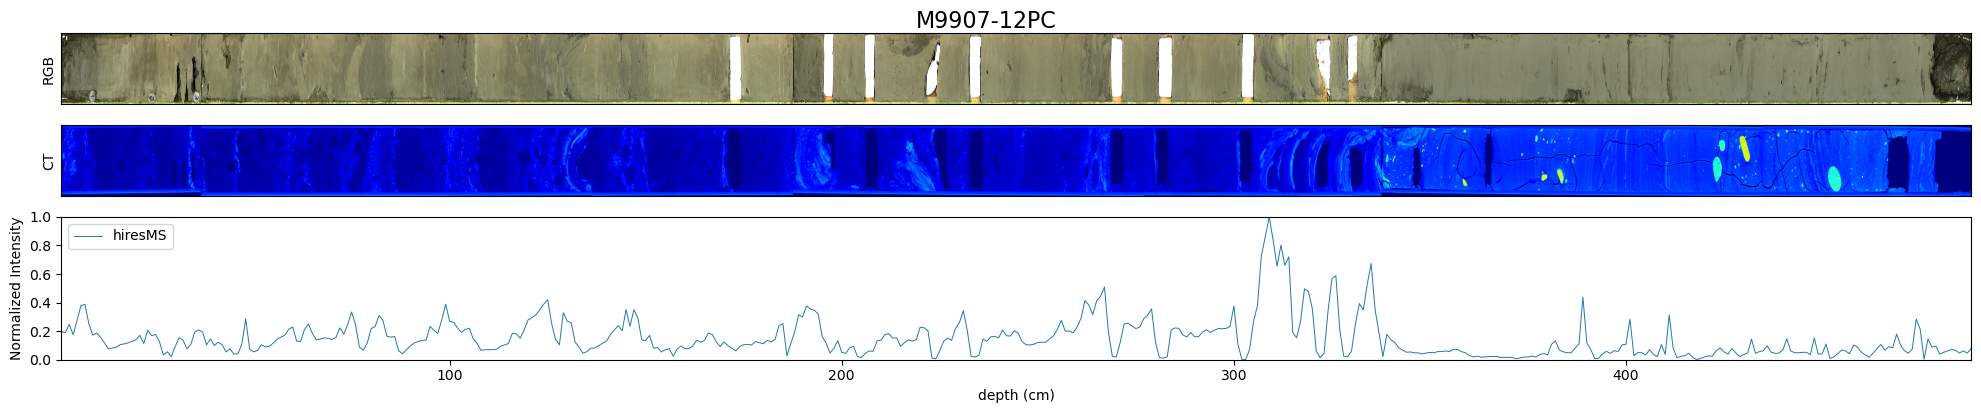

In [11]:
# Define column names to extract from dataset
LOG_COLUMNS = 'hiresMS'
DEPTH_COLUMN = 'SB_DEPTH_cm'

# Define directory paths
mother_dir = '/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/'

# Extract data for the core
core_path = f'{mother_dir}_compiled_logs/{CORE_NAME}/ML_filled/{CORE_NAME}_{LOG_COLUMNS}_MLfilled.csv'
rgb_img_path = mother_dir + '_compiled_logs/' + CORE_NAME + '/' + CORE_NAME + '_RGB.tiff'
ct_img_path = mother_dir + '_compiled_logs/' + CORE_NAME + '/' + CORE_NAME + '_CT.tiff'

# Load images
rgb_img = plt.imread(rgb_img_path)
ct_img = plt.imread(ct_img_path)

# Load log data
df = pd.read_csv(core_path)
log_data = np.array(df[LOG_COLUMNS])
log_data = (log_data - np.min(log_data)) / (np.max(log_data) - np.min(log_data))  # normalize to 0-1
measured_depth = np.array(df[DEPTH_COLUMN])  # measured depth

%matplotlib inline

# Plot core with RGB image, CT image, and log curve
plot_core_data(measured_depth, log_data, CORE_NAME, rgb_img=rgb_img, ct_img=ct_img, label_name=LOG_COLUMNS)
plt.show()


### Interactive picking functions

In [12]:
# Enable the interactive widget backend
def onclick_boundary(event, xs, lines, ax, toolbar, categories, current_category):
    """
    Handle mouse click events: left-click to add x value and vertical line
    Only active when toolbar is not being used
    """
    if event.inaxes == ax and event.name == 'button_press_event':
        # Check if any toolbar buttons are active
        if toolbar.mode == '' and not selection_complete[0]:  # No buttons pressed and selection not complete
            if event.button == 1:  # Left mouse button
                x1 = event.xdata
                xs.append(x1)
                categories.append(current_category[0])
                # Add a vertical red dashed line at the clicked x position
                # Use different colors based on category
                color = get_category_color(current_category[0])
                line = ax.axvline(x=x1, color=color, linestyle='--')
                lines.append(line)
                ax.figure.canvas.draw_idle()
                print(f'Added x={x1:.2f}, Category={current_category[0]}')

def get_category_color(category):
    """Return a color based on the category number"""
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    # Convert category to a hash value if it's a string
    if isinstance(category, str):
        category_hash = sum(ord(c) for c in category)
        return colors[category_hash % len(colors)]
    else:
        return colors[category % len(colors)]

def onkey_boundary(event, xs, lines, ax, cid, toolbar, categories, current_category):
    """
    Handle keyboard events: delete to remove last point, enter to finish, numbers 0-9 to change category
    """
    if event.key and event.key in '0123456789':  # Check if key is a digit between 0-9
        # Change the current category
        current_category[0] = event.key
        print(f'Changed to Category {current_category[0]}')
    elif event.key in ('delete', 'backspace'):
        if xs and not selection_complete[0]:
            removed_x = xs.pop()
            removed_category = categories.pop()
            removed_line = lines.pop()
            removed_line.remove()  # Remove the line from the plot
            ax.figure.canvas.draw_idle()
            print(f'Removed x={removed_x:.2f}, Category={removed_category}')
        else:
            print('No points to remove.')
    elif event.key == 'enter':
        # Sort the picked depths and categories based on depth values (smallest to highest)
        if xs and categories:
            sorted_pairs = sorted(zip(xs, categories), key=lambda pair: (pair[1], pair[0]))
            xs[:] = [pair[0] for pair in sorted_pairs]
            categories[:] = [pair[1] for pair in sorted_pairs]
        # Disconnect the event handlers
        fig.canvas.mpl_disconnect(cid[0])
        fig.canvas.mpl_disconnect(cid[1])
        selection_complete[0] = True
        ax.set_title("Selection Completed")
        print('Finished selecting points. Selection is now locked.')
        
        # Export to CSV if requested when Enter is pressed (now using the sorted values)
        if export_csv_flag[0] and xs:
            export_picked_depths(xs, categories, core_name_global[0])

def create_interactive_figure(md, log, rgb_img=None, ct_img=None, miny=0, maxy=1):
    """
    Create an interactive plot with RGB image, CT image, and log curve.

    :param md: List or array for x-axis data
    :param log: List or array for y-axis data
    :param rgb_img: RGB image data (optional)
    :param ct_img: CT image data (optional)
    :param miny: Minimum y-axis limit
    :param maxy: Maximum y-axis limit
    :return: Matplotlib figure and axes objects
    """
    if rgb_img is not None and ct_img is not None and not isinstance(ct_img, str):
        # Create figure with three subplots if both RGB and CT images are provided
        fig, axs = plt.subplots(3, 1, figsize=(20, 5.5), gridspec_kw={'height_ratios': [1, 1, 2]})
        
        # RGB image - flipping x & y axes
        axs[0].imshow(rgb_img.transpose(1, 0, 2), aspect='auto', extent=[md[0], md[-1], 0, 1])
        axs[0].set_ylabel('RGB')
        axs[0].set_xticks([])  # Hide x-axis ticks for top plots
        axs[0].set_yticks([])  # Hide y-axis ticks for image
        
        # CT image - flipping x & y axes
        axs[1].imshow(ct_img.transpose(1, 0, 2) if len(ct_img.shape) == 3 else 
                      ct_img.transpose(), aspect='auto', extent=[md[0], md[-1], 0, 1], cmap='gray')
        axs[1].set_ylabel('CT')
        axs[1].set_xticks([])  # Hide x-axis ticks for middle plot
        axs[1].set_yticks([])  # Hide y-axis ticks for image
        
        # Log curve
        axs[2].plot(md, log, linestyle='-', linewidth=0.7)  # Using thinner line width of 0.7
        axs[2].set_ylim(miny, maxy)
        axs[2].set_xlim(md[0], md[-1])
        axs[2].set_xlabel('depth (cm)')
        axs[2].set_ylabel('Normalized Intensity')
        axs[2].set_title('Interactive Selection: `Left-Click` to Add, `Delete/Backspace` to Remove, `Enter/Return` to Finish')
        
        plt.tight_layout()
        return fig, axs[2]  # Return the log plot axis for interaction
    
    elif rgb_img is not None:
        # Create figure with two subplots if only RGB image is provided
        fig, axs = plt.subplots(2, 1, figsize=(20, 4), gridspec_kw={'height_ratios': [1, 2]})
        
        # RGB image - flipping x & y axes
        axs[0].imshow(rgb_img.transpose(1, 0, 2), aspect='auto', extent=[md[0], md[-1], 0, 1])
        axs[0].set_ylabel('RGB')
        axs[0].set_xticks([])  # Hide x-axis ticks for top plots
        axs[0].set_yticks([])  # Hide y-axis ticks for image
        
        # Log curve
        axs[1].plot(md, log, linestyle='-', linewidth=0.7)  # Using thinner line width of 0.7
        axs[1].set_ylim(miny, maxy)
        axs[1].set_xlim(md[0], md[-1])
        axs[1].set_xlabel('depth (cm)')
        axs[1].set_ylabel('Normalized Intensity')
        axs[1].set_title('Interactive Selection: `Left-Click` to Add, `Delete/Backspace` to Remove, `Enter/Return` to Finish')
        
        plt.tight_layout()
        return fig, axs[1]  # Return the log plot axis for interaction
    
    elif ct_img is not None and not isinstance(ct_img, str):
        # Create figure with two subplots if only CT image is provided
        fig, axs = plt.subplots(2, 1, figsize=(20, 4), gridspec_kw={'height_ratios': [1, 2]})
        
        # CT image - flipping x & y axes
        axs[0].imshow(ct_img.transpose(1, 0, 2) if len(ct_img.shape) == 3 else 
                      ct_img.transpose(), aspect='auto', extent=[md[0], md[-1], 0, 1], cmap='gray')
        axs[0].set_ylabel('CT')
        axs[0].set_xticks([])  # Hide x-axis ticks for top plots
        axs[0].set_yticks([])  # Hide y-axis ticks for image
        
        # Log curve
        axs[1].plot(md, log, linestyle='-', linewidth=0.7)  # Using thinner line width of 0.7
        axs[1].set_ylim(miny, maxy)
        axs[1].set_xlim(md[0], md[-1])
        axs[1].set_xlabel('depth (cm)')
        axs[1].set_ylabel('Normalized Intensity')
        axs[1].set_title('Interactive Selection: `Left-Click` to Add, `Delete/Backspace` to Remove, `Enter/Return` to Finish')
        
        plt.tight_layout()
        return fig, axs[1]  # Return the log plot axis for interaction
    
    else:
        # Create figure with single subplot if no images or if ct_img is a string
        fig, ax = plt.subplots(figsize=(20, 2.5))
        
        # Log curve
        ax.plot(md, log, linestyle='-', linewidth=0.7)  # Using thinner line width of 0.7
        ax.set_ylim(miny, maxy)
        ax.set_xlim(md[0], md[-1])
        ax.set_xlabel('depth (cm)')
        ax.set_ylabel('Normalized Intensity')
        ax.set_title('Interactive Selection: `Left-Click` to Add, `Delete/Backspace` to Remove, `Enter/Return` to Finish')
        
        plt.tight_layout()
        return fig, ax  # Return the log plot axis for interaction

# Function to export picked depths to CSV
def export_picked_depths(depths, categories, core_name):
    """
    Export picked stratigraphic levels to a CSV file.
    
    :param depths: List of picked depth values
    :param categories: List of categories for each depth
    :param core_name: Name of the core for the filename
    :return: Filename of the saved CSV
    """
    # Create DataFrame with picked depths and categories
    df = pd.DataFrame({
        'picked_depths_cm': depths,
        'category': categories
    })
    
    # Define filename
    filename = f"pickeddepth/{core_name}_pickeddepth.csv"
    
    # Save to CSV
    df.to_csv(filename, index=False)
    print(f"Saved {len(depths)} picked depths to {filename}")

# Define a function to create interactive plot for picking stratigraphic levels
def pick_stratigraphic_levels(md, log, rgb_img=None, ct_img=None, core_name="", log_column_name="", export_csv=False):
    """
    Create an interactive plot for picking stratigraphic levels.
    
    :param md: List or array for x-axis data
    :param log: List or array for y-axis data
    :param rgb_img: RGB image data (optional)
    :param ct_img: CT image data (optional)
    :param core_name: Name of the core for display
    :param log_column_name: Name of the log column for display
    :param export_csv: Boolean flag to export picked depths to CSV when finished
    :return: Tuple of (picked depth values, categories)
    """
    global fig, selection_complete, export_csv_flag, core_name_global
    
    # Create figure and axes
    fig, ax = create_interactive_figure(md, log, rgb_img, ct_img, 0, 1)
    
    # Lists to store picked values, lines, and categories
    xs = []
    lines = []
    categories = []
    current_category = ['1']  # Default category is '1'
    selection_complete = [False]
    export_csv_flag = [export_csv]
    core_name_global = [core_name]
    
    # Get the toolbar instance
    toolbar = fig.canvas.toolbar
    
    # Connect both click and keyboard events to their handlers
    cid = [
        fig.canvas.mpl_connect('button_press_event', 
                              lambda event: onclick_boundary(event, xs, lines, ax, toolbar, categories, current_category)),
        fig.canvas.mpl_connect('key_press_event', 
                              lambda event: onkey_boundary(event, xs, lines, ax, cid, toolbar, categories, current_category))
    ]
    
    # Display instructions
    print("Instructions:")
    print(" - Press any number key (0-9) to change the category of subsequent selections. The default category is set to '1'")
    print(" - Left-click on the plot to select and save an x-value.")
    print(" - Press Delete/Backspace to undo the last selection.")
    print(" - Press Enter when finished selecting points.")
    print(" - Pan and Zoom tools will temporarily disable point selection.")
    if export_csv:
        print(" - [export_csv=True]: Picked depths will be saved to a CSV file when finished.")
    
    fig.suptitle(f'{core_name}', fontsize=16, y=1.02)
    plt.show()
    
    # Return the picked (and sorted) values
    return xs, categories


### Interactive picking for stratigraphic levels

Please pick stratigraphic levels for M9907-12PC
Instructions:
 - Press any number key (0-9) to change the category of subsequent selections. The default category is set to '1'
 - Left-click on the plot to select and save an x-value.
 - Press Delete/Backspace to undo the last selection.
 - Press Enter when finished selecting points.
 - Pan and Zoom tools will temporarily disable point selection.
 - [export_csv=True]: Picked depths will be saved to a CSV file when finished.


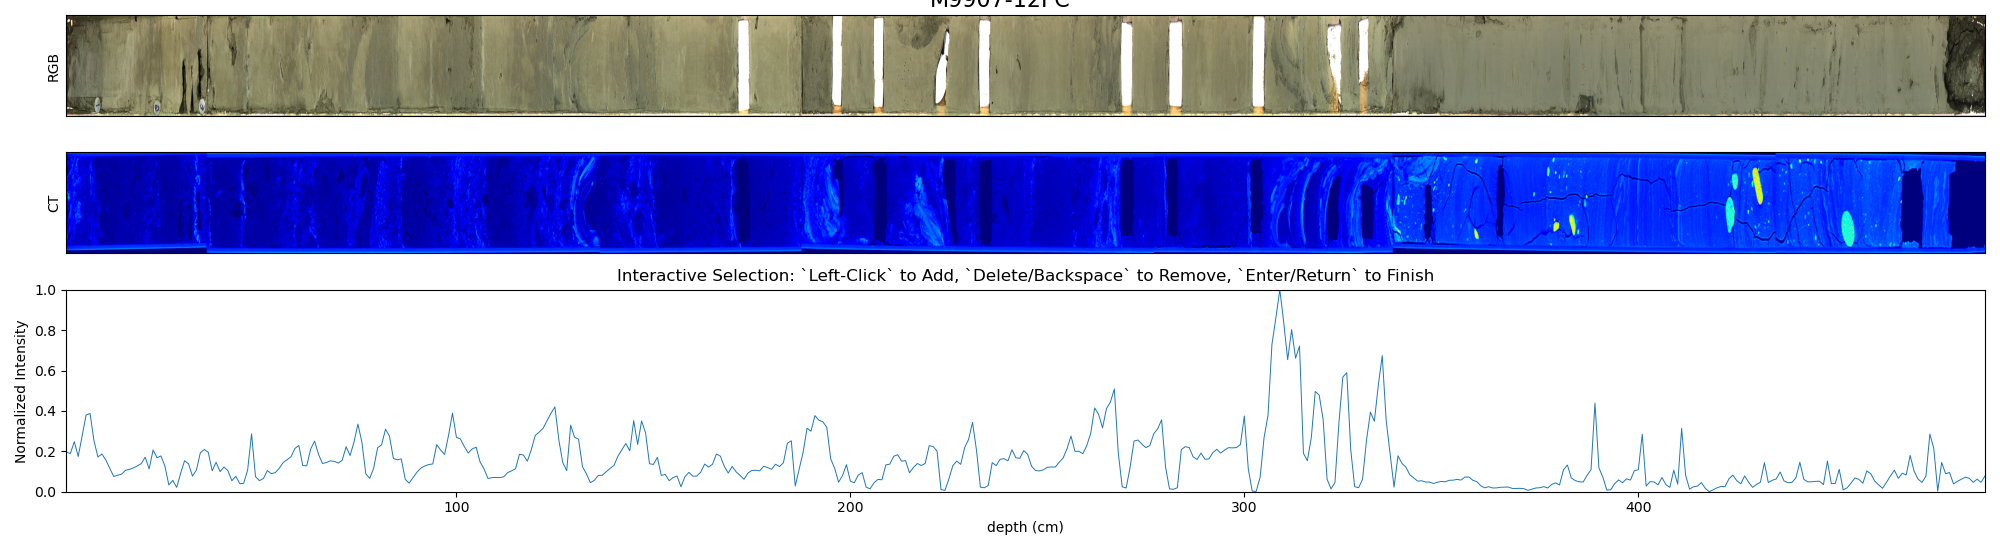

In [13]:
%matplotlib widget 
# should install ipympl

# Pick stratigraphic levels for the core
print(f"Please pick stratigraphic levels for {CORE_NAME}")
picked_depths, picked_categories = pick_stratigraphic_levels(
    measured_depth, log_data, 
    rgb_img=rgb_img, ct_img=ct_img, 
    core_name=CORE_NAME, log_column_name=LOG_COLUMNS, 
    export_csv=True
)


### Sort and save picked depths


In [14]:
# Sort and save the picked depths CSV file
csv_file = f'pickeddepth/{CORE_NAME}_pickeddepth.csv'

if os.path.exists(csv_file):
    df = pd.read_csv(csv_file)
    if not df.empty:
        # Convert columns to numeric types to ensure correct sorting
        df['category'] = pd.to_numeric(df['category'], errors='coerce')
        df['picked_depths_cm'] = pd.to_numeric(df['picked_depths_cm'], errors='coerce')
        # Drop rows with conversion issues
        df = df.dropna(subset=['category', 'picked_depths_cm'])
        
        # Sort first by category, then by picked_depths_cm
        df_sorted = df.sort_values(by=['category', 'picked_depths_cm'])
        # Save the sorted DataFrame back to the CSV file
        df_sorted.to_csv(csv_file, index=False)
        print(f"Sorted and saved {csv_file} with {len(df_sorted)} records.")
    else:
        print(f"File {csv_file} is empty. Skipping sorting.")
else:
    print(f"File {csv_file} not found.")

Sorted and saved pickeddepth/M9907-12PC_pickeddepth.csv with 27 records.


### Visualize picked boundaries


Loaded 27 picked depths for M9907-12PC


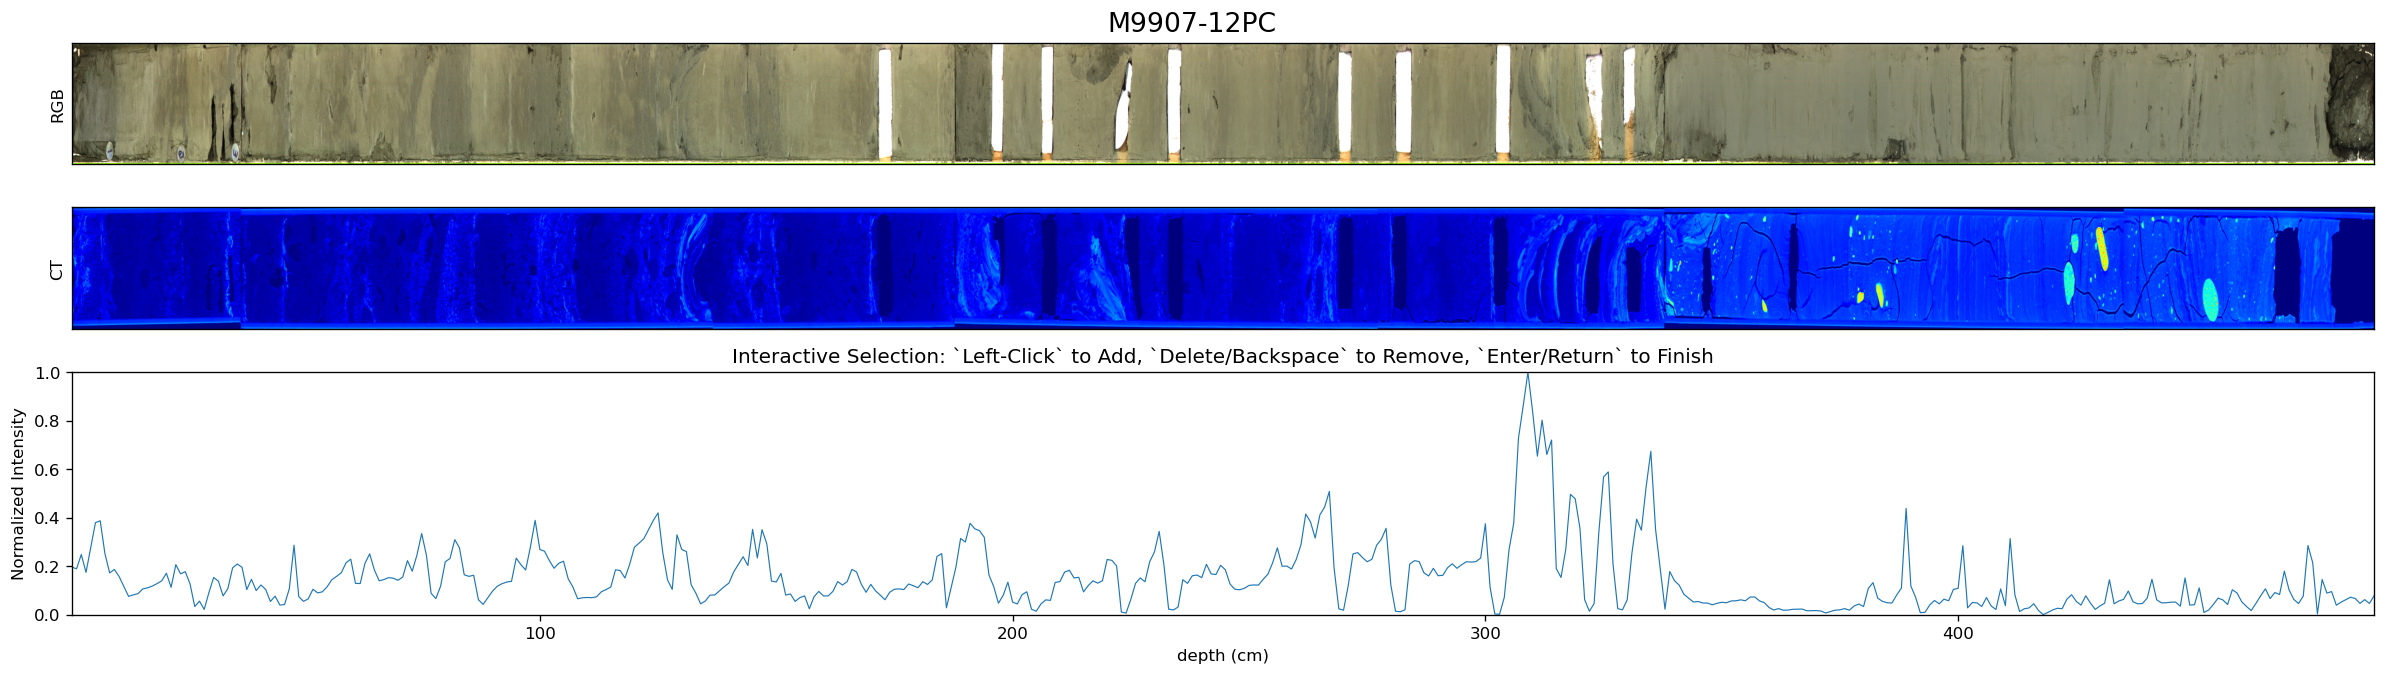

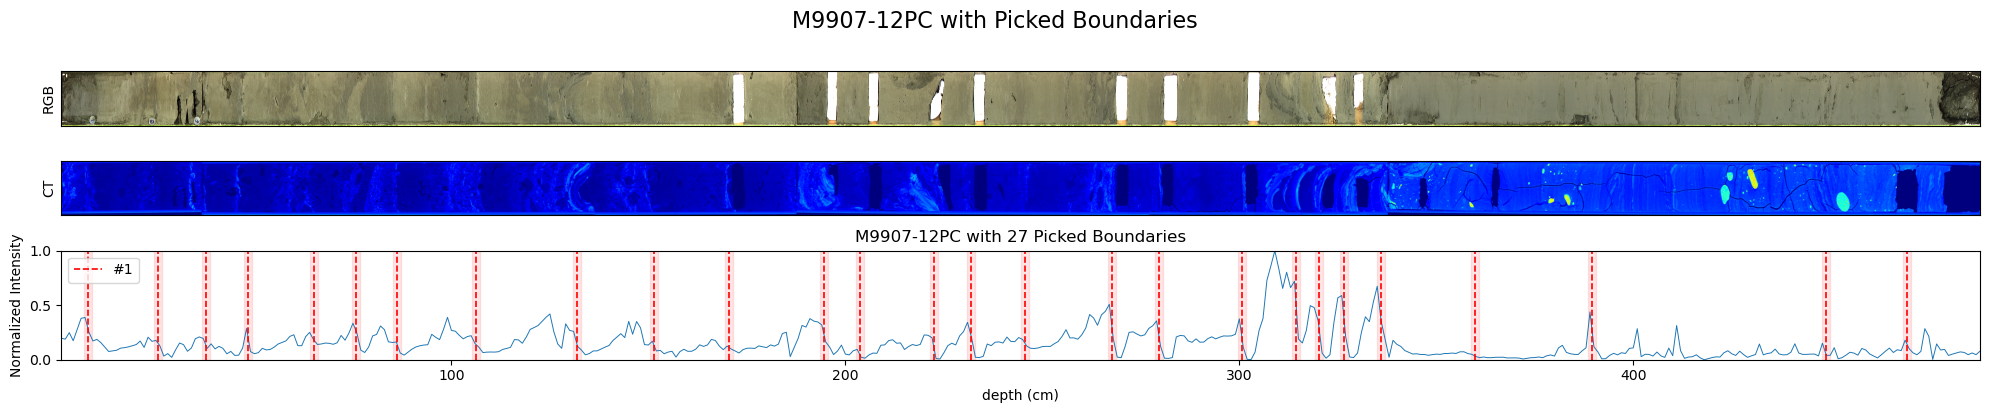

No such comm: 1e86c24ebbef40358a81e309663a2034


In [15]:
%matplotlib inline

# Load picked depths and categories from CSV file
pickeddepth_csv = f'pickeddepth/{CORE_NAME}_pickeddepth.csv'

if os.path.exists(pickeddepth_csv):
    picked_data = pd.read_csv(pickeddepth_csv)
    # Combine depths and categories into tuples
    picked_points = list(zip(picked_data['picked_depths_cm'].values.tolist(), 
                            picked_data['category'].values.tolist()))
    print(f"Loaded {len(picked_points)} picked depths for {CORE_NAME}")
else:
    print(f"Warning: {pickeddepth_csv} not found. Using empty list for picked points.")
    picked_points = []

# Create uncertainty array (assuming uncertainty size is 1 cm)
picked_uncertainty = [1] * len(picked_points)

# Define colors for different categories
category_colors = {
    1: 'red',
    2: 'blue',
    3: 'green',
    4: 'purple',
    5: 'orange',
    6: 'cyan',
    7: 'magenta',
    8: 'yellow',
    9: 'black'
}

# Plot core with picked boundaries colored by category
fig = plot_core_data(measured_depth, log_data, f"{CORE_NAME} with Picked Boundaries", 
                     rgb_img=rgb_img, ct_img=ct_img,
                     figsize=(20, 4))

# Add colored uncertainty shading and boundaries
for (depth, category), uncertainty in zip(picked_points, picked_uncertainty):
    color = category_colors.get(category, 'red')  # Default to red if category not in dictionary
    # Add transparent shading covering the uncertainty interval
    plt.axvspan(depth - uncertainty, depth + uncertainty, color=color, alpha=0.1)
    # Add the picked depth line on top
    plt.axvline(x=depth, color=color, linestyle='--', linewidth=1.2, 
                label=f'#{category}' if f'#{category}' not in plt.gca().get_legend_handles_labels()[1] else "")

# Add legend with unique category entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper left', ncol=len(by_label))
plt.title(f"{CORE_NAME} with {len(picked_points)} Picked Boundaries")

plt.tight_layout()
plt.show()
